In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import re
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

2025-01-28 11:25:44.598303: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-28 11:25:44.598957: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-28 11:25:44.601106: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-28 11:25:44.607543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738059944.619000    1570 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738059944.62

In [2]:
def read_variable_tif_images_to_dataframe(folder_path, base_pattern):
    """
    Reads .tif image files matching the base pattern with varying numbers and creates a pandas DataFrame.
    
    Parameters:
        folder_path (str): Path to the folder containing the .tif image files.
        base_pattern (str): Base file pattern without the varying number (e.g., 'raute_noFlux_128x128_100_H_').
        
    Returns:
        pd.DataFrame: A DataFrame where each row corresponds to a flattened image.
        list: List of original image shapes (rows, columns) for reconstruction.
        list: List of file names corresponding to each image.
    """
    images = []
    image_shapes = []
    file_names = []
    
    # Regular expression to match files with the base pattern and varying numbers
    pattern = re.compile(f"{base_pattern}[0-9]+\\.tif")
    
    # Loop through all files in the folder
    for file_name in os.listdir(folder_path):
        if pattern.fullmatch(file_name):
            file_path = os.path.join(folder_path, file_name)
            image = Image.open(file_path).convert("L")
            #print(image.size)
            image_array = np.array(image)
            
            images.append(image_array.flatten())
            image_shapes.append(image_array.shape)
            file_names.append(file_name)
    
    # Create DataFrame
    df = pd.DataFrame(images, index=file_names)
    return df, image_shapes, file_names

def display_images(df, image_shapes, file_names, num_images=5):
    """
    Displays a few images from the DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing flattened image data.
        image_shapes (list): List of tuples containing the original image shapes.
        file_names (list): List of file names corresponding to each image.
        num_images (int): Number of images to display.
    """
    for i in range(min(num_images, len(df))):
        image_flat = df.iloc[i].to_numpy()
        image_shape = image_shapes[i]
        image = image_flat.reshape(image_shape)
        
        plt.figure()
        plt.imshow(image, cmap="gray")
        plt.title(f"Image: {file_names[i]}")
        plt.axis("off")
        plt.show()


In [3]:
# Specify the folder path and base file pattern
folder_path = "/home/uashfaq/InverseDesign/new_dataset/projects/disjoint/out"
base_pattern = "raute_noFlux_128x128_100_H_"

# Read .tif images matching the pattern into a DataFrame
image_df, image_shapes, file_names = read_variable_tif_images_to_dataframe(folder_path, base_pattern)

In [4]:
image_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
raute_noFlux_128x128_100_H_1008.tif,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
raute_noFlux_128x128_100_H_3251.tif,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
raute_noFlux_128x128_100_H_1733.tif,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
raute_noFlux_128x128_100_H_2290.tif,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
raute_noFlux_128x128_100_H_3911.tif,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


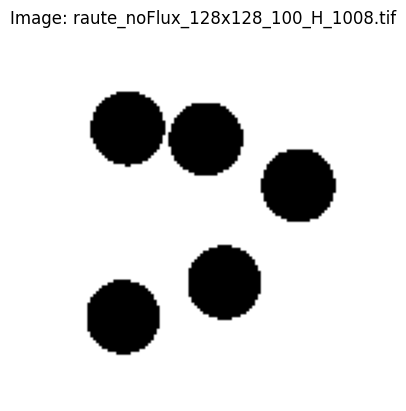

In [5]:
# Display a few images
display_images(image_df, image_shapes, file_names, num_images=1)

In [6]:
image_df.shape

(5000, 16384)

In [7]:
# Define the encoder
class Sampling(layers.Layer):
    def call(self, inputs):
        """Reparameterization trick: sample from N(0, 1) scaled by the learned parameters."""
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(image_shape, latent_dim):
    encoder_inputs = layers.Input(shape=image_shape)
    x = layers.Conv2D(32, (3, 3), activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, (3, 3), activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

# Define the decoder
def build_decoder(latent_dim, original_shape):
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(32 * 32 * 64, activation="relu")(decoder_inputs)
    x = layers.Reshape((32, 32, 64))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(original_shape[-1], (3, 3), activation="sigmoid", padding="same")(x)
    decoder = models.Model(decoder_inputs, decoder_outputs, name="decoder")
    return decoder

# Define the VAE
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(
                tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            ))
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}

In [8]:
# Prepare the dataset
def preprocess_images(df, image_shapes):
    """Preprocess the flattened images back to their original shape and normalize."""
    images = [df.iloc[i].to_numpy().reshape(image_shapes[i]) for i in range(len(df))]
    images = np.stack(images)
    # Add a channel dimension for grayscale images
    images = images[..., np.newaxis]
    return images.astype("float32") / 255.0

images = preprocess_images(image_df, image_shapes)

In [9]:
# Instantiate and compile the VAE
latent_dim = 64
image_shape = (128, 128, 1)
encoder = build_encoder(image_shape, latent_dim)
decoder = build_decoder(latent_dim, image_shape)
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())


early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=20, restore_best_weights=True)


# Train the VAE
history = vae.fit(images, epochs=1000, batch_size=32,  callbacks=[early_stopping])

Epoch 1/1000


2025-01-28 11:26:17.195055: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 150ms/step - kl_loss: 53.6673 - loss: 5442.8062 - reconstruction_loss: 5389.1387
Epoch 2/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 28s 178ms/step - kl_loss: 94.1399 - loss: 3828.2029 - reconstruction_loss: 3734.0630
Epoch 3/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 53s 341ms/step - kl_loss: 116.0484 - loss: 3104.7622 - reconstruction_loss: 2988.7139
Epoch 4/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 206ms/step - kl_loss: 130.7900 - loss: 2648.3765 - reconstruction_loss: 2517.5864
Epoch 5/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 203ms/step - kl_loss: 136.6796 - loss: 2431.3315 - reconstruction_loss: 2294.6521
Epoch 6/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 203ms/step - kl_loss: 141.9646 - loss: 2263.7549 - reconstruction_loss: 2121.7903
Epoch 7/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 204ms/step - kl_loss: 146.8304 - loss: 2142.9548 - reconstruction_loss: 1996.1244
Epoch 8/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 202ms/step - kl_loss: 149.2760 - loss: 2025.0032 - reconstruction_loss: 1

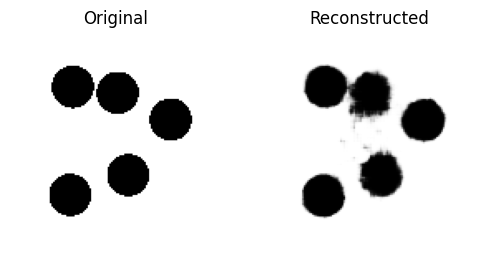

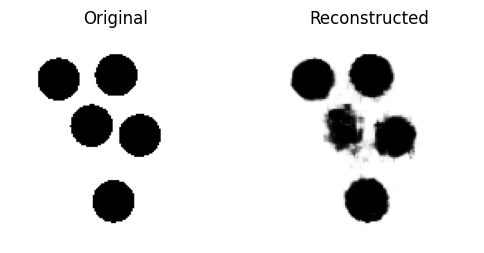

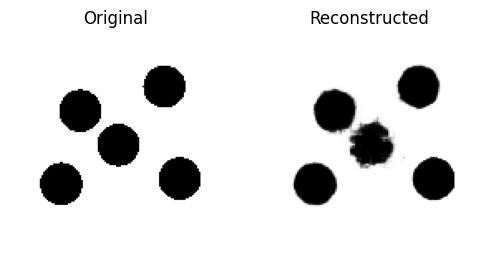

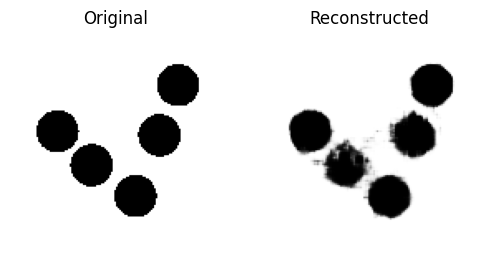

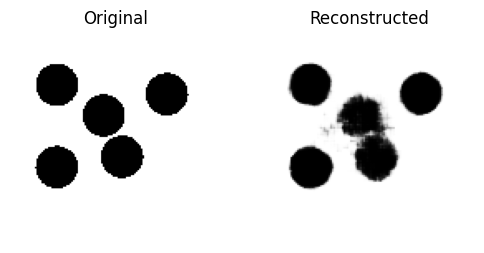

In [12]:
# Show original and reconstructed images
sample_images = images[:5]  # Select the first 5 images
reconstructed_images = vae.decoder(vae.encoder(sample_images)[2]).numpy()

for i in range(len(sample_images)):
    plt.figure(figsize=(6, 3))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(sample_images[i], cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Reconstructed image
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_images[i], cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()

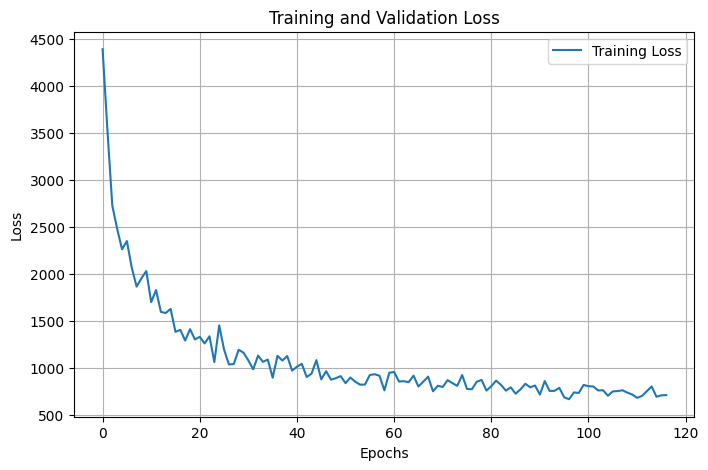

In [13]:
# Extract loss and validation loss from history
loss = history.history['loss']
#val_loss = history.history['val_loss']

# Plot the training and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


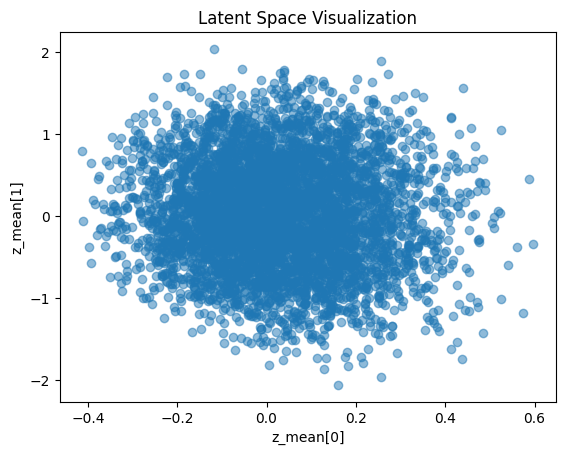

In [14]:
# Visualize the latent space
z_mean, z_log_var, _ = encoder.predict(images)
plt.scatter(z_mean[:, 0], z_mean[:, 1], alpha=0.5)
plt.title("Latent Space Visualization")
plt.xlabel("z_mean[0]")
plt.ylabel("z_mean[1]")
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


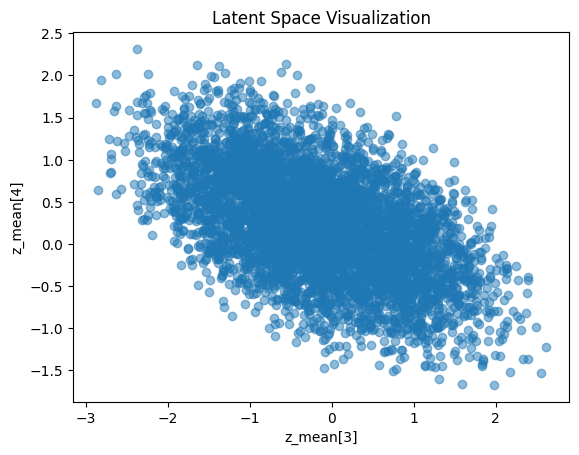

In [15]:
# Visualize the latent space
z_mean, z_log_var, _ = encoder.predict(images)
plt.scatter(z_mean[:, 62], z_mean[:, 63], alpha=0.5)
plt.title("Latent Space Visualization")
plt.xlabel("z_mean[3]")
plt.ylabel("z_mean[4]")
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


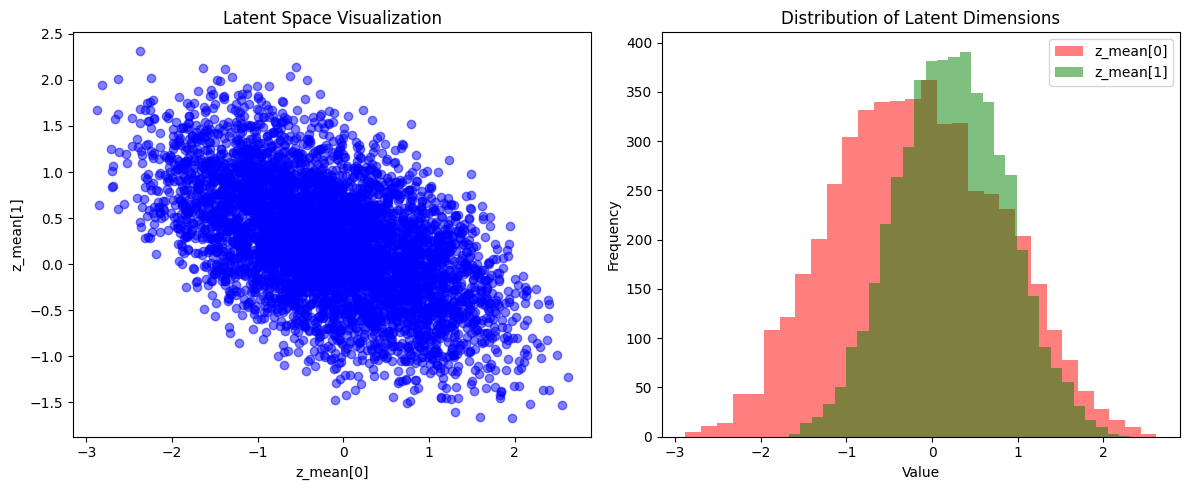

In [16]:
# Visualize the latent space
z_mean, z_log_var, _ = encoder.predict(images)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)

plt.scatter(z_mean[:, 62], z_mean[:, 63], alpha=0.5, color='blue')

plt.title("Latent Space Visualization")

plt.xlabel("z_mean[0]")

plt.ylabel("z_mean[1]")



# Plot 2: Distribution of z_mean[0] and z_mean[1]

plt.subplot(1, 2, 2)

plt.hist(z_mean[:, 62], bins=30, alpha=0.5, label='z_mean[0]', color='red')

plt.hist(z_mean[:, 63], bins=30, alpha=0.5, label='z_mean[1]', color='green')

plt.title("Distribution of Latent Dimensions")

plt.xlabel("Value")

plt.ylabel("Frequency")

plt.legend()



plt.tight_layout()

plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


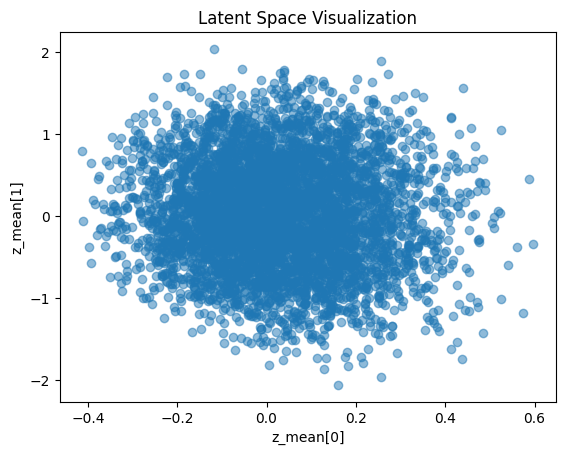

In [17]:
# Visualize the latent space
z_mean, z_log_var, _ = encoder.predict(images)
plt.scatter(z_mean[:, 0], z_mean[:, 1], alpha=0.5)
plt.title("Latent Space Visualization")
plt.xlabel("z_mean[0]")
plt.ylabel("z_mean[1]")
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


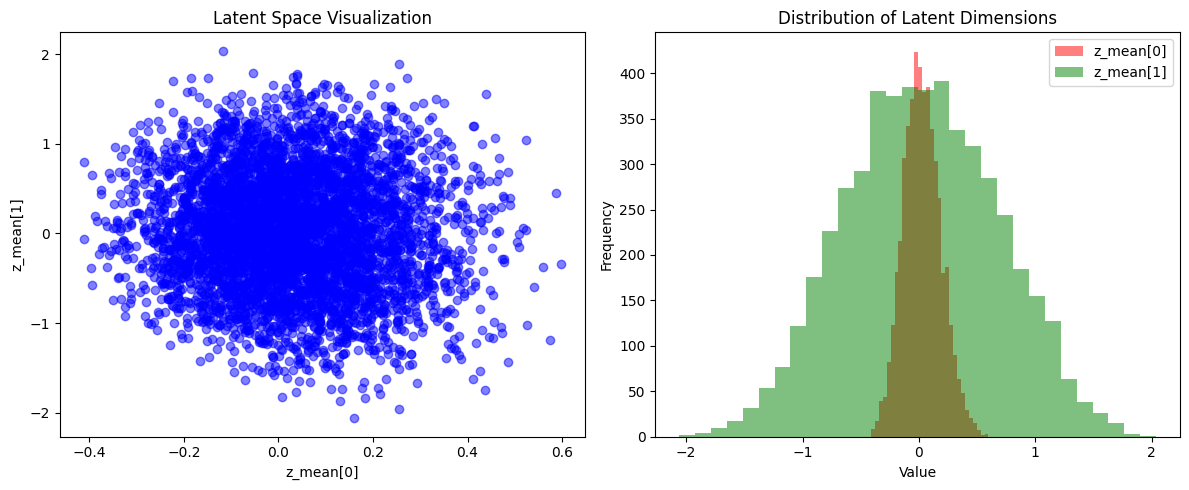

In [18]:
# Visualize the latent space
z_mean, z_log_var, _ = encoder.predict(images)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)

plt.scatter(z_mean[:, 0], z_mean[:, 1], alpha=0.5, color='blue')

plt.title("Latent Space Visualization")

plt.xlabel("z_mean[0]")

plt.ylabel("z_mean[1]")



# Plot 2: Distribution of z_mean[0] and z_mean[1]

plt.subplot(1, 2, 2)

plt.hist(z_mean[:, 0], bins=30, alpha=0.5, label='z_mean[0]', color='red')

plt.hist(z_mean[:, 1], bins=30, alpha=0.5, label='z_mean[1]', color='green')

plt.title("Distribution of Latent Dimensions")

plt.xlabel("Value")

plt.ylabel("Frequency")

plt.legend()



plt.tight_layout()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


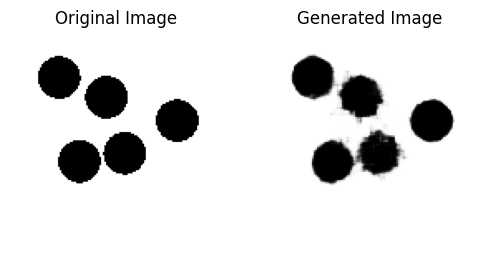

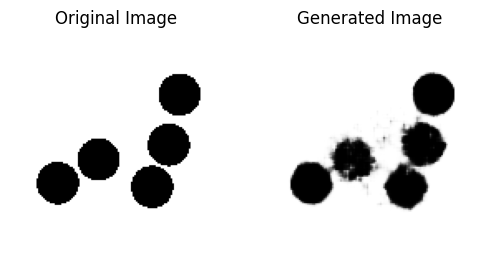

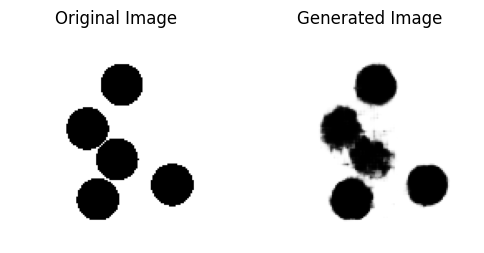

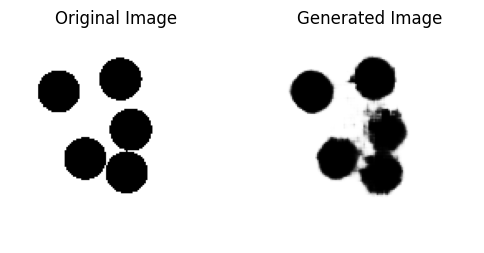

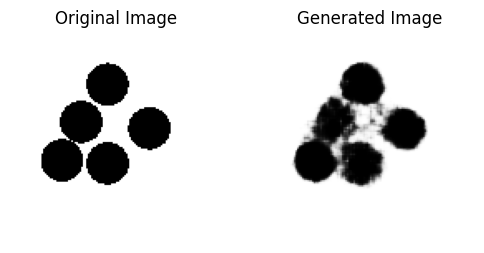

In [19]:
# Modified function to sample and return original and generated images
def sample_and_plot_original_generated(vae, images, num_samples=5):
    """
    Samples random images from the dataset, generates new images from the VAE,
    and plots the original and generated images side by side.
    
    Parameters:
        vae (VAE): The trained VAE model.plt.figure(figsize=(12, 5))
        images (np.ndarray): The training dataset (normalized images).
    """
    # Select random indices from the dataset
    random_indices = np.random.choice(len(images), num_samples, replace=False)
    original_images = images[random_indices]  # Original images

    # Get latent space mean and log variance for the selected images
    z_mean, z_log_var, _ = vae.encoder.predict(original_images)

    # Sample latent vectors using the reparameterization trick
    sampled_latent_vectors = []
    for i in range(num_samples):
        mean = z_mean[i]
        log_var = z_log_var[i]
        epsilon = np.random.normal(size=mean.shape)
        sampled_latent_vector = mean + np.exp(0.5 * log_var) * epsilon
        sampled_latent_vectors.append(sampled_latent_vector)
    
    sampled_latent_vectors = np.array(sampled_latent_vectors)

    # Decode the sampled latent vectors into images
    generated_images = vae.decoder.predict(sampled_latent_vectors)

    # Plot original and generated images side by side
    for i in range(num_samples):
        plt.figure(figsize=(6, 3))
        
        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_images[i], cmap="gray")
        plt.title("Original Image")
        plt.axis("off")
        
        # Generated image
        plt.subplot(1, 2, 2)
        plt.imshow(generated_images[i], cmap="gray")
        plt.title("Generated Image")
        plt.axis("off")
        
        plt.show()

# Use the modified function to plot original and generated images
num_samples = 5  # Number of images to sample and generate
sample_and_plot_original_generated(vae, images, num_samples=num_samples)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


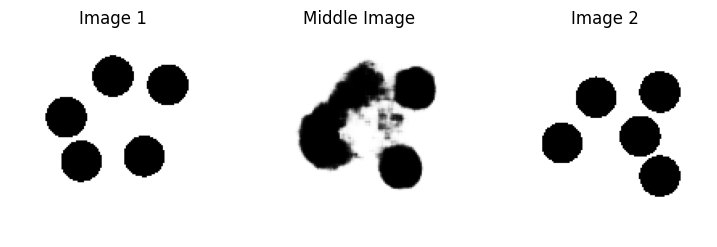

In [20]:
# Generate a middle image between two samples
def generate_middle_image(vae, images):
    """
    Generate a middle image by interpolating between two random images in the latent space.

    Parameters:
        vae (VAE): The trained VAE model.
        images (np.ndarray): The training dataset# Visualize the latent space
    """
    # Select two random images
    idx1, idx2 = np.random.choice(len(images), 2, replace=False)
    image1, image2 = images[idx1], images[idx2]

    # Encode the images to get latent representations
    z_mean1, _, _ = vae.encoder.predict(np.expand_dims(image1, axis=0))
    z_mean2, _, _ = vae.encoder.predict(np.expand_dims(image2, axis=0))

    # Interpolate between the two latent vectors
    z_middle = 0.5 * (z_mean1 + z_mean2)

    # Decode the interpolated latent vector to generate the middle image
    middle_image = vae.decoder.predict(z_middle)

    # Plot the original images and the middle image
    plt.figure(figsize=(9, 3))

    # Original image 1
    plt.subplot(1, 3, 1)
    plt.imshow(image1, cmap="gray")
    plt.title("Image 1")
    plt.axis("off")

    # Middle image
    plt.subplot(1, 3, 2)
    plt.imshow(middle_image[0], cmap="gray")
    plt.title("Middle Image")
    plt.axis("off")

    # Original image 2
    plt.subplot(1, 3, 3)
    plt.imshow(image2, cmap="gray")
    plt.title("Image 2")
    plt.axis("off")

    plt.show()

# Generate and display the middle image
generate_middle_image(vae, images)


In [21]:
# Save the latent space vectors to a CSV file
z_mean, z_log_var, _ = encoder.predict(images)
latent_space_df = pd.DataFrame(z_mean, index=image_df.index)
latent_space_df.to_csv("latent_space_vectors.csv")

print("Latent space vectors saved to 'latent_space_vectors_5000.csv'.")


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Latent space vectors saved to 'latent_space_vectors_5000.csv'.
